# **Part 1 - Credit Union Wealth Relationships**

---


**Phase 1 - Data Import**

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16,8]
sns.set()


SEED = 1

#import data and create X & y sets
df = pd.read_csv('Member.csv', encoding = "ISO-8859-1")


**Phase 2 - Data Preprocessing**

---



In [139]:
#create dummy variables for all categorical variables
df_d = pd.get_dummies(df)
y = df_d.iloc[:,0]
X = df_d.iloc[:,1:]
X.shape

(116050, 22)

In [4]:
#create correlation matrix for all 53 variables to see if there are obvious features that can be dropped
corr = df_d.corr()
corr.style.background_gradient()

In [5]:
#retain the two interesting categorical variables, get rid of the rest
df['LastContacted_Never'] = np.where((df.LastContacted == "Never"), 1, 0)
df['MaritalStatus_Married'] = np.where((df.MaritalStatus == "Married"), 1, 0)
df = df.drop(['Region', 'MaritalStatus', 'Gender', 'ConexusDebtShare', 'LastContacted','RuralUrban'], axis=1)
df_d = pd.get_dummies(df)
y = df_d.iloc[:,0]
X = df_d.iloc[:,1:]
X.head()

,Age,Tenure,HasDemand,DemandBalance,HasConsumerMortgage,ConsumerMortgageRemainingBalance,HasConsumerLoanProduct,HasCreditCard,Driver1,Driver2,...,Driver5,Driver6,Driver7,AverageMonthlyExpenses,CreditVisionScore,BranchToDigitalIndex,HasOnlineBanking,TouchPointsCount,LastContacted_Never,MaritalStatus_Married
0,34,30,1,15010.93,1,-197179.54,1,1,66,100,...,63,100.00,100,5270.45,830,0.94,1,3,0,0
1,51,29,1,489104.48,0,0.00,0,0,58,100,...,100,83.33,100,9773.08,814,0.48,1,8,0,0
2,43,32,1,6495.45,0,0.00,0,0,33,100,...,0,0.00,100,4568.80,853,0.97,1,1,0,0
3,78,52,1,2689.43,0,0.00,1,0,41,100,...,2,0.00,100,3494.25,793,0.00,1,1,0,0
4,31,18,0,141.08,0,0.00,1,0,-1,-1,...,-1,-1.00,-1,-1.00,748,0.00,0,0,1,0


In [6]:
#validate the new correlation matrix to ensure relevancy of remaining features versus response 
corr = df_d.corr()
corr.style.background_gradient()

,HasCAM_CSI,Age,Tenure,HasDemand,DemandBalance,HasConsumerMortgage,ConsumerMortgageRemainingBalance,HasConsumerLoanProduct,HasCreditCard,Driver1,Driver2,Driver3,Driver4,Driver5,Driver6,Driver7,AverageMonthlyExpenses,CreditVisionScore,BranchToDigitalIndex,HasOnlineBanking,TouchPointsCount,LastContacted_Never,MaritalStatus_Married
HasCAM_CSI,1,0.0705684,0.117975,0.0700635,0.0636226,0.125292,-0.107209,0.161659,0.159711,0.132191,0.238424,0.158818,0.165889,0.115742,0.190985,0.23162,0.179506,0.156285,0.163134,0.106078,0.195217,-0.153694,0.0982491
Age,0.0705684,1,0.549617,-0.117626,0.228991,-0.024229,0.0447018,0.0797419,-0.0684871,0.128324,0.302097,0.223425,0.335365,0.146532,0.0379613,0.257945,0.064747,0.481109,-0.104917,-0.207953,0.113741,-0.0130343,0.19539
Tenure,0.117975,0.549617,1,-0.0112493,0.196705,-0.00584387,0.0376324,0.153968,0.0334067,0.132516,0.333866,0.200206,0.335791,0.152806,0.146734,0.297778,0.132143,0.301025,0.0144754,-0.14167,0.133585,0.00573848,0.0997466
HasDemand,0.0700635,-0.117626,-0.0112493,1,0.0997798,0.0650582,-0.048408,0.240297,0.150849,0.193274,0.154808,0.171401,0.123314,0.112921,0.142204,0.13234,0.131583,-0.118411,0.0985717,0.231008,0.191964,-0.329316,-0.146131
DemandBalance,0.0636226,0.228991,0.196705,0.0997798,1,-0.0296363,0.0245555,0.00453081,0.0264371,0.137658,0.186982,0.135369,0.287686,0.221402,0.101141,0.125207,0.0875459,0.0814901,-0.0510819,-0.0726408,0.337003,-0.11723,0.0159727
HasConsumerMortgage,0.125292,-0.024229,-0.00584387,0.0650582,-0.0296363,1,-0.803535,0.248728,0.147016,0.034082,0.126293,0.0610803,-0.0218481,-0.0139118,0.109112,0.161445,0.192043,0.121732,0.180541,0.130997,0.156207,-0.163776,0.128793
ConsumerMortgageRemainingBalance,-0.107209,0.0447018,0.0376324,-0.048408,0.0245555,-0.803535,1,-0.201203,-0.124239,-0.0192886,-0.0995559,-0.0431248,0.0310036,0.0172779,-0.0788252,-0.124822,-0.186346,-0.0959004,-0.160113,-0.116544,-0.128948,0.132968,-0.126303
HasConsumerLoanProduct,0.161659,0.0797419,0.153968,0.240297,0.00453081,0.248728,-0.201203,1,0.268581,0.155461,0.317162,0.199773,0.0679742,0.048118,0.232363,0.361835,0.321942,0.2678,0.319416,0.267663,0.189279,-0.228287,0.110953
HasCreditCard,0.159711,-0.0684871,0.0334067,0.150849,0.0264371,0.147016,-0.124239,0.268581,1,0.172105,0.27981,0.197296,0.13775,0.106197,0.245767,0.339676,0.239521,0.201574,0.258364,0.209337,0.16926,-0.191566,0.0226464
Driver1,0.132191,0.128324,0.132516,0.193274,0.137658,0.034082,-0.0192886,0.155461,0.172105,1,0.568542,0.646557,0.519524,0.656689,0.349398,0.568172,0.286671,0.197589,0.278925,0.233338,0.232116,-0.258208,0.031851


In [7]:
#undersample the data to rebalance the classes to parity
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
rus.fit(X, y)
X_resampled, y_resampled = rus.fit_resample(X, y)
X_rs = pd.DataFrame(X_resampled, columns = X.columns)
y_rs = pd.DataFrame(y_resampled, columns = ["HasCAM_CSI"])
result = pd.concat([y_rs, X_rs], axis=1)

#shed 75% of the remaining data to cut down on computing complexity
result = result.sample(frac=0.25, replace=False, random_state=1)
y_res = result.iloc[:,0]
X_res = result.iloc[:,1:]
print(X_res.shape)

(5834, 22)


In [8]:
#split data into 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=SEED)

from sklearn.preprocessing import StandardScaler

#instantiate a scalar
scaler = StandardScaler()

# Fit only to the training data
scaler.fit(X_train)

# Now apply the transformations to the data:
X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform(X_test)
X_train_scale

# Now apply the transformations to the data:
X_train_all = scaler.transform(X)
X_train_all

C:\Users\e4129\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.


array([[-0.82976558,  0.86745983,  0.35602017, ...,  0.36143617,
        -0.46679961, -0.62998981],
       [ 0.06015509,  0.78799929,  0.35602017, ...,  2.0975648 ,
        -0.46679961, -0.62998981],
       [-0.35863111,  1.02638091,  0.35602017, ..., -0.33301529,
        -0.46679961, -0.62998981],
       ...,
       [-2.60960691, -1.51635636, -2.80882962, ..., -0.33301529,
        -0.46679961, -0.62998981],
       [-2.60960691, -1.51635636, -2.80882962, ..., -0.33301529,
        -0.46679961, -0.62998981],
       [-0.93446213, -1.51635636, -2.80882962, ..., -0.33301529,
        -0.46679961,  1.58732726]])

In [9]:
#create function to visualize confusion matrix
# from: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [10]:
print(__doc__)

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring="f1")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

Automatically created module for IPython interactive environment


**Phase 3 - Classification Tree**

---



In [71]:
#CART ----------------------------------------------------------------------------------------------------
from sklearn.tree import DecisionTreeClassifier
#set class weights
weights = np.linspace(0.4, 0.4, 1)
classes = [{0: x, 1: 1.0-x} for x in weights]

#define the grid of hyperparameters
params_dt = {'class_weight': classes,'max_depth': [3,4,5,6], 'min_samples_leaf':[0.05], 'max_features':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], 'criterion':['entropy']}

#instantiate Decision Tree
dt = DecisionTreeClassifier(random_state=SEED)

#instantiate a 10-fold CV grid search object
grid_dt = GridSearchCV(estimator=dt, param_grid=params_dt, scoring='f1', cv=5, n_jobs=-1)

#Fit grid_dt to the training data
grid_dt.fit(X_train, y_train)

#extract the best params from 'grid_dt'
best_hyperparams = grid_dt.best_params_
print(best_hyperparams)

#extract best CV score 
best_CV_score = grid_dt.best_score_
print(best_CV_score)

#extract best model from grid_dt
best_model = grid_dt.best_estimator_

#refit the best model to all training data
best = best_model.fit(X_train,y_train)

#make predictions on test data
y_pred = best.predict(X_test)

{'class_weight': {0: 0.4, 1: 0.6}, 'criterion': 'entropy', 'max_depth': 4, 'max_features': 0.6, 'min_samples_leaf': 0.05}
0.74171367513195


In [72]:
#create confusion & classification matrix
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred,digits=3))

[[318 309]
 [ 72 468]]
              precision    recall  f1-score   support

           0      0.815     0.507     0.625       627
           1      0.602     0.867     0.711       540

   micro avg      0.674     0.674     0.674      1167
   macro avg      0.709     0.687     0.668      1167
weighted avg      0.717     0.674     0.665      1167



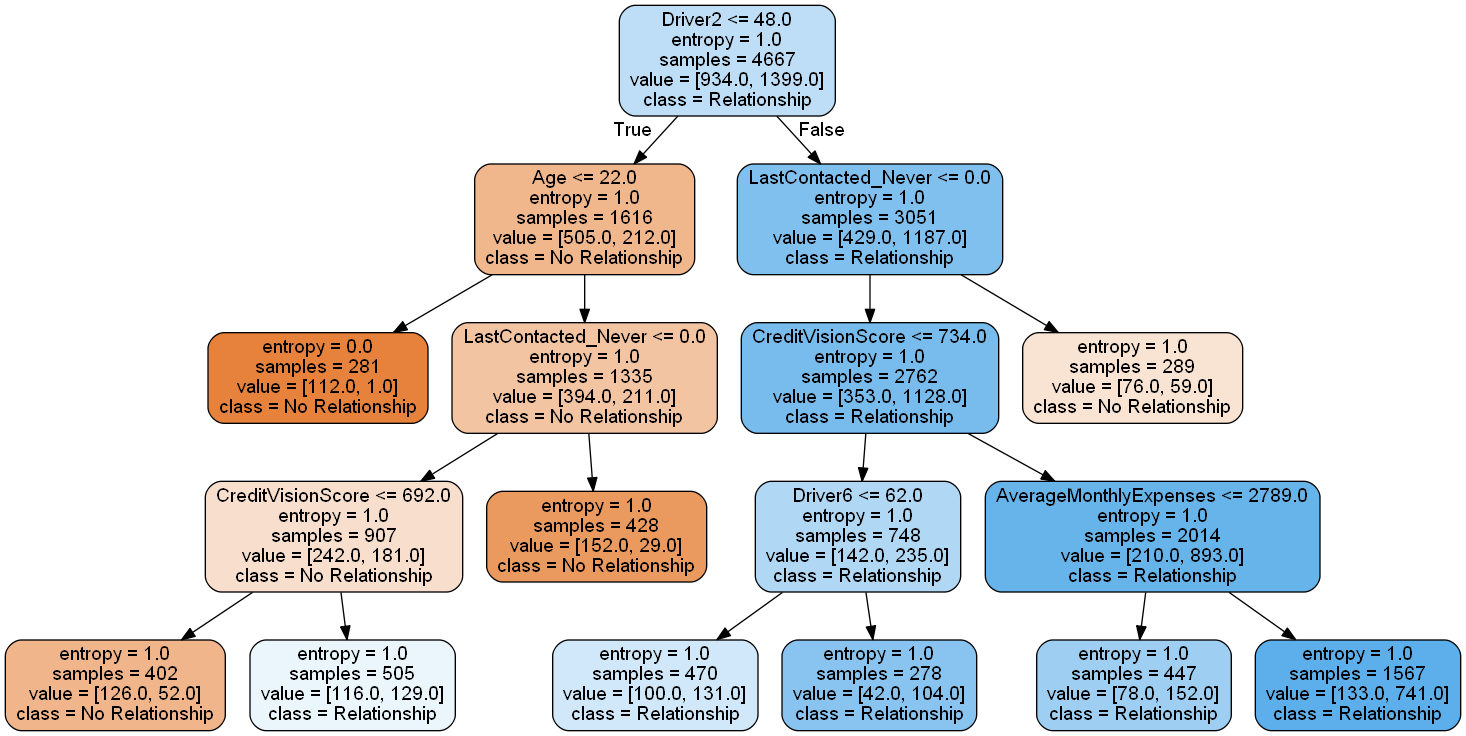

In [13]:
#generate and visually display optimal decision tree
from sklearn import tree
tree.export_graphviz(best, out_file='tree2.dot', feature_names = X.columns, class_names = ["No Relationship", "Relationship"],rounded = True, proportion = False, precision = 0, filled = True)
!dot -Tpng tree2.dot -o tree2.png
from IPython.display import Image
Image(filename = 'tree2.png')

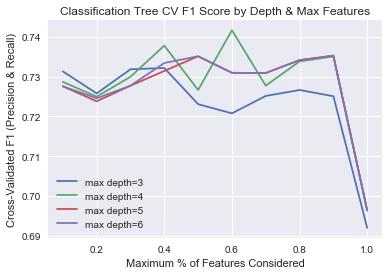

In [14]:
# plot the GridSearchCV results showing max tree depth versus % of features considered
xp = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
plt.plot(xp, list(grid_dt.cv_results_['mean_test_score'][:10]), label="max depth=3")
plt.plot(xp, list(grid_dt.cv_results_['mean_test_score'][10:20]), label="max depth=4")
plt.plot(xp, list(grid_dt.cv_results_['mean_test_score'][20:30]), label="max depth=5")
plt.plot(xp, list(grid_dt.cv_results_['mean_test_score'][30:]), label="max depth=6")
plt.title('Classification Tree CV F1 Score by Depth & Max Features')
plt.xlabel('Maximum % of Features Considered')
plt.ylabel('Cross-Validated F1 (Precision & Recall)')
plt.legend()

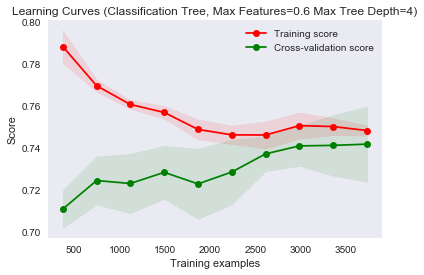

In [15]:
#plot the learning curve for the optimal Classification Tree model
title = "Learning Curves (Classification Tree, Max Features=0.6 Max Tree Depth=4)"
plot_learning_curve(best_model, title, X_train_scale, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, n_jobs=-1)
plt.show()

**Phase 4 - AdaBoost Tree Boosting **

---



In [73]:
#AdaBoost--------------------------------------------------------------------------------------------
from sklearn.ensemble import AdaBoostClassifier

#instantiate a base classification tree 'dtb'
dtb = DecisionTreeClassifier(random_state=SEED)

#define the grid of hyperparameters
#set class weights
weights = np.linspace(0.35, 0.35, 1)
classes = [{0: x, 1: 1.0-x} for x in weights]
params_ada = {'base_estimator__max_depth': [1], 'n_estimators':[10,100,500,1000,2000,3000,4000], 'learning_rate':[0.05,0.005,0.5],'base_estimator__criterion':['gini'], 'base_estimator__class_weight': classes}

#instantiate an adaboost classifier
adb_clf = AdaBoostClassifier(base_estimator=dtb, random_state=SEED)
adb_clf.get_params()

#instantiate a 10-fold CV grid search object
grid_ada = GridSearchCV(estimator=adb_clf, param_grid=params_ada, scoring='f1', cv=5, n_jobs=-1, verbose=3)
grid_ada.get_params()

#Fit grid_ada to the training data
grid_ada.fit(X_train_scale, y_train)

#extract the best params from 'grid_ada'
best_hyperparams = grid_ada.best_params_
print(best_hyperparams)

#extract best CV score 
best_CV_score = grid_ada.best_score_
print(best_CV_score)

#extract best model from grid_ada
best_ada = grid_ada.best_estimator_

#refit the best model to all training data
best = best_ada.fit(X_train_scale,y_train)

#make predictions on test data
y_pred = best.predict(X_test_scale)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:  6.2min finished


{'base_estimator__class_weight': {0: 0.35, 1: 0.65}, 'base_estimator__criterion': 'gini', 'base_estimator__max_depth': 1, 'learning_rate': 0.005, 'n_estimators': 3000}
0.7656805977393486


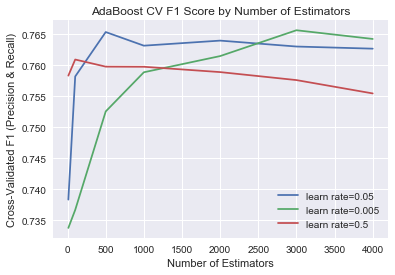

In [74]:
# plot the results showing learning rate versus number of base estimators
xp = [10,100,500,1000,2000,3000,4000]
plt.plot(xp, list(grid_ada.cv_results_['mean_test_score'][:7]), label="learn rate=0.05")
plt.plot(xp, list(grid_ada.cv_results_['mean_test_score'][7:14]), label="learn rate=0.005")
plt.plot(xp, list(grid_ada.cv_results_['mean_test_score'][14:]), label="learn rate=0.5")
plt.title('AdaBoost CV F1 Score by Number of Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('Cross-Validated F1 (Precision & Recall)')
plt.legend()

Confusion matrix, without normalization
[[348 279]
 [ 71 469]]


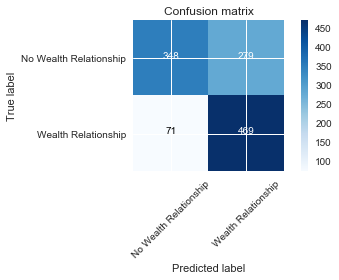

In [75]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["No Wealth Relationship", "Wealth Relationship"],
                      title='Confusion matrix')

In [76]:
#create confusion & classification matrix
print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred,digits=3))

0.7000856898029134
[[348 279]
 [ 71 469]]
              precision    recall  f1-score   support

           0      0.831     0.555     0.665       627
           1      0.627     0.869     0.728       540

   micro avg      0.700     0.700     0.700      1167
   macro avg      0.729     0.712     0.697      1167
weighted avg      0.736     0.700     0.694      1167



In [20]:
#display the most important features of the AdaBoost
best.feature_importances_
both = zip(list(best.feature_importances_),X_rs.columns)
ndf = pd.DataFrame(list(both), columns=['Importance', 'Feature'])
ndf.sort_values('Importance',ascending=False,inplace=True)
ndf

,Importance,Feature
0,0.281000,Age
16,0.108000,CreditVisionScore
20,0.075000,LastContacted_Never
19,0.072333,TouchPointsCount
1,0.068000,Tenure
7,0.058333,HasCreditCard
15,0.049000,AverageMonthlyExpenses
13,0.044000,Driver6
3,0.041000,DemandBalance
17,0.040667,BranchToDigitalIndex


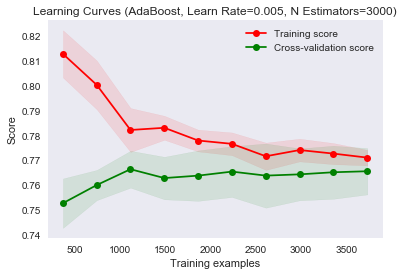

In [21]:
#plot the learning curve for AdaBoost
title = "Learning Curves (AdaBoost, Learn Rate=0.005, N Estimators=3000)"
plot_learning_curve(best_ada, title, X_train_scale, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, n_jobs=-1)
plt.show()

**Phase 5 - XGBoost Tree Boosting**

---



In [126]:
#XGBoost -------------------------------------------------------------------------------------------------
from xgboost import XGBClassifier

# fit model no training data
xgb = XGBClassifier(objective='binary:logistic',
                    silent=True)

#set parmeter grid
params = {
        'min_child_weight': [5],
        'n_estimators':[10,50,100,250,500,1000,2000,3500],
        'learning_rate' : [0.1,0.01,0.001],
        'gamma': [1],
        'subsample': [0.6],
        'colsample_bytree': [0.4],
        'max_depth': [1,2],
        'scale_pos_weight': [1.3]
        }

#create GridSearchCV object and fit it versus training data
grid = GridSearchCV(estimator=xgb, param_grid=params, scoring='f1', n_jobs=-1, cv=5, verbose=3 )
grid.fit(X_train_scale, y_train)

#extract the best params from 'grid'
best_hyperparams = grid.best_params_
print(best_hyperparams)

#extract best CV score 
best_CV_score = grid.best_score_
print(best_CV_score)

#extract best model from grid
best_xg = grid.best_estimator_

#Fit the model to the data
best = best_xg.fit(X_train_scale,y_train)

#make predictions on test data
y_pred = best.predict(X_test_scale)
predictions = [round(value) for value in y_pred]

#create confusion & classification matrix
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions,digits=3))

#extract the most imporatant features for xgboost
best.feature_importances_
both = zip(list(best.feature_importances_),X_res.columns)
ndf = pd.DataFrame(list(both), columns=['Importance', 'Feature'])
ndf.sort_values('Importance',ascending=False,inplace=True)
print(ndf)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  2.0min finished


{'colsample_bytree': 0.4, 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 2000, 'scale_pos_weight': 1.3, 'subsample': 0.6}
0.7683588480992696
[[423 204]
 [105 435]]
              precision    recall  f1-score   support

           0      0.801     0.675     0.732       627
           1      0.681     0.806     0.738       540

   micro avg      0.735     0.735     0.735      1167
   macro avg      0.741     0.740     0.735      1167
weighted avg      0.745     0.735     0.735      1167

    Importance                           Feature
0     0.133413                               Age
3     0.098386                     DemandBalance
16    0.096154                 CreditVisionScore
15    0.093750            AverageMonthlyExpenses
1     0.075893                            Tenure
11    0.062328                           Driver4
17    0.053400              BranchToDigitalIndex
19    0.052713                  TouchPointsCount
14    0.042582           

In [69]:
#function to lighten line colours on a matplotlib plot
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

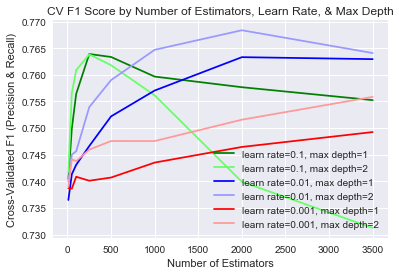

In [70]:
# plot the results showing cross-validated F1 scores by number of estimators, max base estimator depth, and learning rate
xi = [10,50,100,250,500,1000,2000,3500]
plt.plot(xi, list(grid.cv_results_['mean_test_score'][:8]), label="learn rate=0.1, max depth=1", color='g')
plt.plot(xi, list(grid.cv_results_['mean_test_score'][8:16]), label="learn rate=0.1, max depth=2",color=lighten_color('g', 0.4))
plt.plot(xi, list(grid.cv_results_['mean_test_score'][16:24]), label="learn rate=0.01, max depth=1", color='b')
plt.plot(xi, list(grid.cv_results_['mean_test_score'][24:32]), label="learn rate=0.01, max depth=2",color=lighten_color('b', 0.4))
plt.plot(xi, list(grid.cv_results_['mean_test_score'][32:40]), label="learn rate=0.001, max depth=1", color='r')
plt.plot(xi, list(grid.cv_results_['mean_test_score'][40:]), label="learn rate=0.001, max depth=2",color=lighten_color('r', 0.4))
plt.title('CV F1 Score by Number of Estimators, Learn Rate, & Max Depth')
plt.xlabel('Number of Estimators')
plt.ylabel('Cross-Validated F1 (Precision & Recall)')
plt.legend()

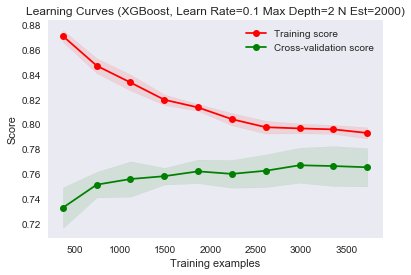

In [79]:
#plot the learning curve for XGBoost
title = "Learning Curves (XGBoost, Learn Rate=0.1 Max Depth=2 N Est=2000)"
plot_learning_curve(best_xg, title, X_train_scale, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, n_jobs=-1)
plt.show()

Confusion matrix, without normalization
[[401 226]
 [ 90 450]]


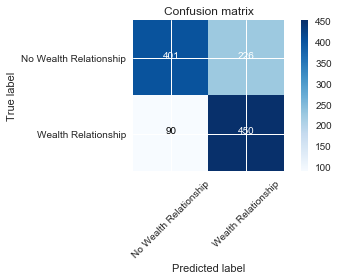

In [26]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, predictions)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["No Wealth Relationship", "Wealth Relationship"],
                      title='Confusion matrix')

In [127]:
#make predictions on all data
predall = best.predict(X_train_all)

#create confusion & classification matrix for test data
print(confusion_matrix(y,predall))
print(classification_report(y,predall, digits=3))

[[68698 35683]
 [ 1950  9719]]
              precision    recall  f1-score   support

           0      0.972     0.658     0.785    104381
           1      0.214     0.833     0.341     11669

   micro avg      0.676     0.676     0.676    116050
   macro avg      0.593     0.746     0.563    116050
weighted avg      0.896     0.676     0.740    116050



In [133]:
predprob = best.predict_proba(X_train_all)
predprob

array([[0.05, 0.95],
       [0.13, 0.87],
       [0.23, 0.77],
       ...,
       [0.99, 0.01],
       [0.99, 0.01],
       [0.94, 0.06]], dtype=float32)

In [152]:
#create a dataframe that combines probabilities with original X variables
df_new = pd.concat([pd.DataFrame(list(predprob[:,1]), columns=["Wealth_Prob"]), X],axis=1)
df_n = pd.concat([pd.DataFrame(y, columns = ["HasCAM_CSI"]), df_new],axis=1)

#take a copy of X
X_copy = X.copy()

#make changes to contact variables
X_copy['LastContacted_Never']=X_copy['LastContacted_Never'].apply(lambda x: 0 if x == 1 else 0)
X_copy['TouchPointsCount']=X_copy['TouchPointsCount'].apply(lambda x: 2 if x == 0 else x)

# Now apply the transformations to the data:
X_scale_all = scaler.transform(X_copy)

#obtain new probabilities based on shocking contacts
predprobnew = best.predict_proba(X_scale_all)
predprobnew

#add new probabilities to this table
df_f = pd.concat([pd.DataFrame(list(predprobnew[:,1]), columns=["Shock_Wealth_Prob"]), df_n],axis=1)

#output to excel
df_f.to_excel("output.xlsx")

C:\Users\e4129\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  del sys.path[0]


**Phase 6 - Instance-Based K-Nearest Neighbors**

---



In [80]:
#KNN--------------------------------------------------------------------------------------------------
from sklearn.neighbors import KNeighborsClassifier

# define the parameter values that should be searched
k_range = list(range(1, 30,2))
weight_options = ['distance', 'uniform']

# create a parameter grid: 
param_grid = dict(weights=weight_options, n_neighbors=k_range)

# instantiate and fit the gridsearch
knn = KNeighborsClassifier()
grid_knn = GridSearchCV(knn, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=3)
grid_knn.fit(X_train_scale, y_train)

#extract the best params from 'grid_knn'
best_hyperparams = grid_knn.best_params_
print(best_hyperparams)

#extract best CV score 
best_CV_score = grid_knn.best_score_
print(best_CV_score)

#extract best model from grid_knn
best_knn = grid_knn.best_estimator_

#refit the best model to all training data
best = best_knn.fit(X_train_scale,y_train)

#predict test set labels
y_pred = best.predict(X_test_scale)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   44.9s finished


{'n_neighbors': 23, 'weights': 'distance'}
0.7460763436941372


In [81]:
#create confusion & classification matrix
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred,digits=3))

[[426 201]
 [116 424]]
              precision    recall  f1-score   support

           0      0.786     0.679     0.729       627
           1      0.678     0.785     0.728       540

   micro avg      0.728     0.728     0.728      1167
   macro avg      0.732     0.732     0.728      1167
weighted avg      0.736     0.728     0.728      1167



Confusion matrix, without normalization
[[426 201]
 [116 424]]


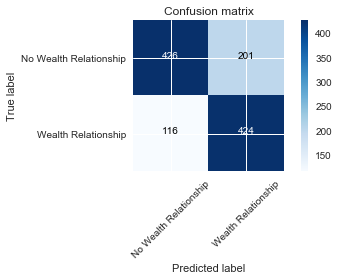

In [29]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["No Wealth Relationship", "Wealth Relationship"],
                      title='Confusion matrix')

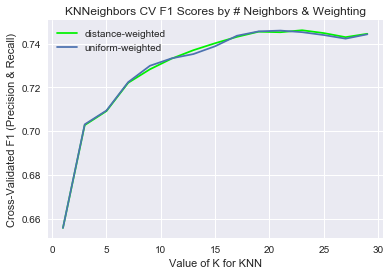

In [30]:
# plot the results showing cross-validated F1 by weighting metric and number of neighbors
plt.plot(k_range, list(grid_knn.cv_results_['mean_test_score'][0::2]), label="distance-weighted",color=lighten_color('g', 0.7))
plt.plot(k_range, list(grid_knn.cv_results_['mean_test_score'][1::2]), label="uniform-weighted")
plt.title("KNNeighbors CV F1 Scores by # Neighbors & Weighting")
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated F1 (Precision & Recall)')
plt.legend()

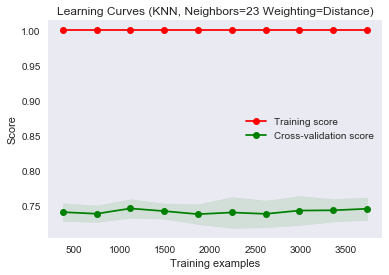

In [31]:
#plot the learning curve for optimal KNN model
title = "Learning Curves (KNN, Neighbors=23 Weighting=Distance)"
plot_learning_curve(best_knn, title, X_train_scale, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, n_jobs=-1)
plt.show()

**Phase 7 - Neural Networks**

---



In [87]:
#Neural Network------------------------------------------------------
from sklearn.neural_network import MLPClassifier

#create gridSearch parameters
parameters = {'solver': ['adam'], 'max_iter': [10,50,100,175,250], 'alpha': [2], 'hidden_layer_sizes':[10,100,250,400]}

#run GridSearch to optimize parameters
clf = GridSearchCV(MLPClassifier(random_state=SEED), param_grid=parameters, scoring='f1', cv=5, n_jobs=-1, verbose=3)
clf.fit(X_train_scale,y_train)

#extract the best params from 'clf'
best_hyperparams = clf.best_params_
print(best_hyperparams)

#extract best CV score 
best_CV_score = clf.best_score_
print(best_CV_score)

#extract best model from clf
best_nn = clf.best_estimator_

#Fit the model to the data
best = best_nn.fit(X_train_scale,y_train)

#make predictions on test data
y_pred = best.predict(X_test_scale)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished
C:\Users\e4129\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


{'alpha': 2, 'hidden_layer_sizes': 400, 'max_iter': 50, 'solver': 'adam'}
0.753051329049756


C:\Users\e4129\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [88]:
#create confusion & classification matrix for test data
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred,digits=3))

[[451 176]
 [121 419]]
              precision    recall  f1-score   support

           0      0.788     0.719     0.752       627
           1      0.704     0.776     0.738       540

   micro avg      0.746     0.746     0.746      1167
   macro avg      0.746     0.748     0.745      1167
weighted avg      0.749     0.746     0.746      1167



Confusion matrix, without normalization
[[451 176]
 [121 419]]


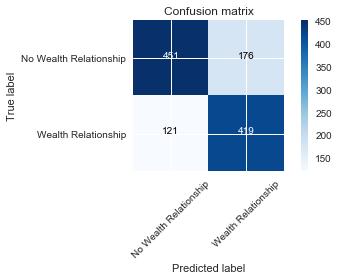

In [89]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["No Wealth Relationship", "Wealth Relationship"],
                      title='Confusion matrix')

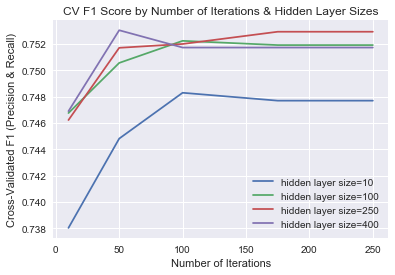

In [90]:
# plot the results showing cross-validated F1 scores by hidden layer sizes and number of model iterations
xp = [10,50,100,175,250]
plt.plot(xp, list(clf.cv_results_['mean_test_score'][:5]), label="hidden layer size=10")
plt.plot(xp, list(clf.cv_results_['mean_test_score'][5:10]), label="hidden layer size=100")
plt.plot(xp, list(clf.cv_results_['mean_test_score'][10:15]), label="hidden layer size=250")
plt.plot(xp, list(clf.cv_results_['mean_test_score'][15:]), label="hidden layer size=400")
plt.title('CV F1 Score by Number of Iterations & Hidden Layer Sizes')
plt.xlabel('Number of Iterations')
plt.ylabel('Cross-Validated F1 (Precision & Recall)')
plt.legend()

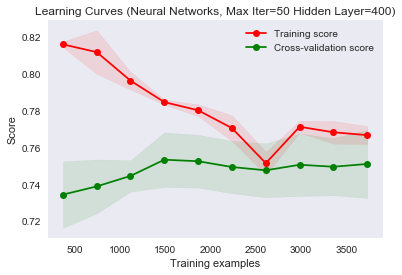

In [91]:
#plot the learning curve for Neural Network
title = "Learning Curves (Neural Networks, Max Iter=50 Hidden Layer=400)"
plot_learning_curve(best_nn, title, X_train_scale, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, n_jobs=-1)
plt.show()

**Phase 8 - Support Vector Machines - Linear SVC**

---



In [92]:
#Support Vector Machines (linearSVC) --------------------------------------------------------------------------
from sklearn import svm

#set parameter grid
weights = np.linspace(0.2,0.5, 8)
Cs = np.linspace(0.0001,0.02, 40)
classes = [{0: x, 1: 1.0-x} for x in weights]
param_grid = {'C' : Cs, 'class_weight' : classes}

#create and run grid search
support = GridSearchCV(svm.LinearSVC(dual=False), param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=3)
support.fit(X_train_scale, y_train)

#extract the best params from 'support'
best_hyperparams = support.best_params_
print(best_hyperparams)

#extract best CV score 
best_CV_score = support.best_score_
print(best_CV_score)

#extract best model from support
best_lsvc = support.best_estimator_

#Fit the model to the data
best = best_lsvc.fit(X_train_scale,y_train)

#make predictions on test data
predictions = best.predict(X_test_scale)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 856 tasks      | elapsed:   12.5s


{'C': 0.009794871794871795, 'class_weight': {0: 0.37142857142857144, 1: 0.6285714285714286}}
0.7561538986117071


[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:   24.8s finished


In [93]:
#create confusion & classification matrix for test data
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions,digits=3))

[[336 291]
 [ 62 478]]
              precision    recall  f1-score   support

           0      0.844     0.536     0.656       627
           1      0.622     0.885     0.730       540

   micro avg      0.698     0.698     0.698      1167
   macro avg      0.733     0.711     0.693      1167
weighted avg      0.741     0.698     0.690      1167



Confusion matrix, without normalization
[[336 291]
 [ 62 478]]


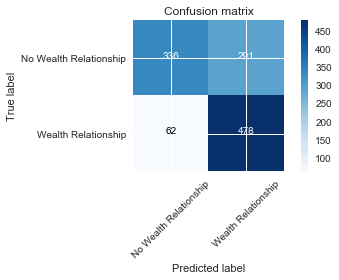

In [39]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, predictions)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["No Wealth Relationship", "Wealth Relationship"],
                      title='Confusion matrix')

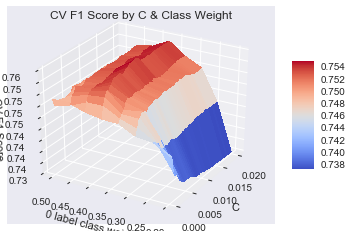

In [94]:
'''
======================
3D surface (color map)
======================

Demonstrates plotting a 3D surface colored with the coolwarm color map.
The surface is made opaque by using antialiased=False.

Also demonstrates using the LinearLocator and custom formatting for the
z axis tick labels.
from: https://matplotlib.org/examples/mplot3d/surface3d_demo.html
and https://stackoverflow.com/questions/9170838/surface-plots-in-matplotlib/30539444#30539444
'''

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from scipy.interpolate import griddata

# Make data.
Z = support.cv_results_['mean_test_score']
X = np.ma.getdata(support.cv_results_['param_C'])
Y = np.array([x[0] for x in [[v for k,v in d.items() if k==0] for d in np.ma.getdata(support.cv_results_['param_class_weight'])]])

# re-create the 2D-arrays
x1 = np.linspace(X.min(), X.max(), len(np.unique(X)))
y1 = np.linspace(Y.min(), Y.max(), len(np.unique(Y)))
x2, y2 = np.meshgrid(x1, y1)
z2 = griddata((X, Y), Z, (x2, y2), method='cubic')

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x2, y2, z2, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_zlabel('CV F1 Score')

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('CV F1 Score by C & Class Weight')
plt.xlabel('C')
plt.ylabel('0 label class weight')
ax.view_init(azim=210)

plt.show()

In [95]:
#display the best features of the linearsvc
best.coef_
both = zip(list(best.coef_[0]),X_rs.columns)
ndf = pd.DataFrame(list(both), columns=['Coefficient', 'Feature'])
ndf.sort_values('Coefficient',ascending=False,inplace=True)
ndf

,Coefficient,Feature
9,0.224198,Driver2
16,0.189182,CreditVisionScore
17,0.076757,BranchToDigitalIndex
19,0.067720,TouchPointsCount
7,0.066173,HasCreditCard
21,0.063655,MaritalStatus_Married
13,0.047842,Driver6
18,0.045154,HasOnlineBanking
15,0.044996,AverageMonthlyExpenses
1,0.034656,Tenure


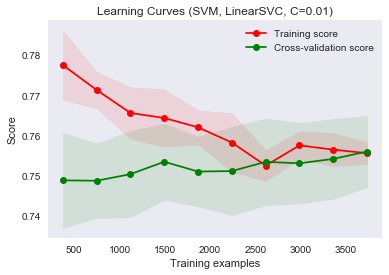

In [96]:
#plot the learning curve for LinearSVC
title = "Learning Curves (SVM, LinearSVC, C=0.01)"
plot_learning_curve(best_lsvc, title, X_train_scale, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, n_jobs=-1)
plt.show()

**Phase 9 - Support Vector Machines - NonLinear 'RBF' Kernel SVC**

---



In [113]:
#Support Vector Machines (NonLinear)--------------------------------------------------------------------------
from sklearn import svm

#set parameter grid
weights = np.linspace(0.45, 0.45, 1)
Cs = [0.1,1,2.5,5,10,15,20]
classes = [{0: x, 1: 1.0-x} for x in weights]
kernels = ['rbf']#, 'linear', 'sigmoid', 'rbf', ]
gammas = [1,0.5,0.1,0.05,0.01,0.001]
param_grid = {'kernel' : kernels, 'class_weight' : classes, 'C': Cs, 'gamma':gammas}

#create and run grid search
support = GridSearchCV(svm.SVC(probability=True), param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=3)
support.fit(X_train_scale, y_train)

#extract the best params from 'support'
best_hyperparams = support.best_params_
print(best_hyperparams)

#extract best CV score 
best_CV_score = support.best_score_
print(best_CV_score)

#extract best model from support
best_nlsvc = support.best_estimator_

#Fit the model to the data
best = best_nlsvc.fit(X_train_scale,y_train)

#make predictions on test data
predictions = best.predict(X_test_scale)

Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:  7.4min finished


{'C': 10, 'class_weight': {0: 0.45, 1: 0.55}, 'gamma': 0.01, 'kernel': 'rbf'}
0.7567520692603026


In [98]:
#create confusion & classification matrix for test data
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions, digits=3))

[[409 218]
 [106 434]]
              precision    recall  f1-score   support

           0      0.794     0.652     0.716       627
           1      0.666     0.804     0.728       540

   micro avg      0.722     0.722     0.722      1167
   macro avg      0.730     0.728     0.722      1167
weighted avg      0.735     0.722     0.722      1167



Confusion matrix, without normalization
[[409 218]
 [106 434]]


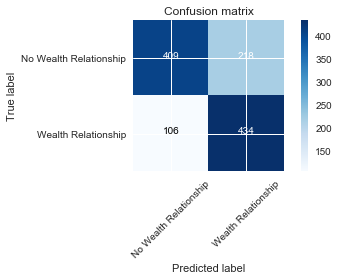

In [99]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, predictions)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["No Wealth Relationship", "Wealth Relationship"],
                      title='Confusion matrix')

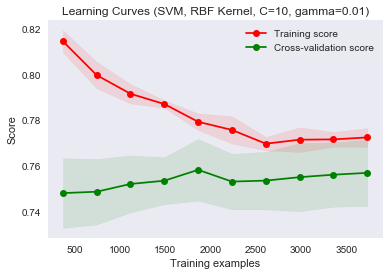

In [100]:
#plot the learning curve for NonLinearSVC
title = "Learning Curves (SVM, RBF Kernel, C=10, gamma=0.01)"
plot_learning_curve(best_nlsvc, title, X_train_scale, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, n_jobs=-1)
plt.show()

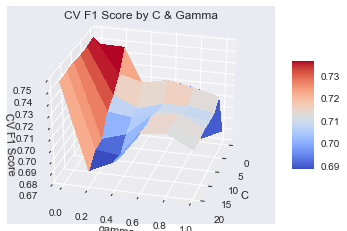

In [103]:
'''
======================
3D surface (color map)
======================

Demonstrates plotting a 3D surface colored with the coolwarm color map.
The surface is made opaque by using antialiased=False.

Also demonstrates using the LinearLocator and custom formatting for the
z axis tick labels.
from: https://matplotlib.org/examples/mplot3d/surface3d_demo.html
and https://stackoverflow.com/questions/9170838/surface-plots-in-matplotlib/30539444#30539444
'''

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from scipy.interpolate import griddata

# Make data.
Z = support.cv_results_['mean_test_score']
X = np.ma.getdata(support.cv_results_['param_C'])
Y = np.ma.getdata(support.cv_results_['param_gamma'])

# re-create the 2D-arrays
x1 = np.linspace(X.min(), X.max(), len(np.unique(X)))
y1 = np.linspace(Y.min(), Y.max(), len(np.unique(Y)))
x2, y2 = np.meshgrid(x1, y1)
z2 = griddata((X, Y), Z, (x2, y2), method='cubic')

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x2, y2, z2, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_zlabel('CV F1 Score')

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('CV F1 Score by C & Gamma')
plt.xlabel('C')
plt.ylabel('gamma')
ax.view_init(azim=15)

plt.show()

**Phase 10 - Logistic Regression**

---



In [104]:
#Logistic Regression --------------------------------------------------------------------------
from sklearn.linear_model import LogisticRegression

#set parameter grid
weights = np.linspace(0.2, 0.55, 10)
solvers = ['liblinear']
Cs = [10,12,8]
maxi = [250,200]
classes = [{0: x, 1: 1.0-x} for x in weights]
param_grid = {'class_weight' : classes, 'solver' : solvers, 'C' : Cs, 'max_iter' : maxi}

#create and run grid search
support = GridSearchCV(LogisticRegression(), param_grid, scoring='f1', cv=5, n_jobs=-1)
support.fit(X_train_scale, y_train)

#extract the best params from 'support'
best_hyperparams = support.best_params_
print(best_hyperparams)

#extract best CV score 
best_CV_score = support.best_score_
print(best_CV_score)

#extract best model from support
best_lr = support.best_estimator_

#Fit the model to the data
best = best_lr.fit(X_train_scale,y_train)

#make predictions on test data
predictions = best.predict(X_test_scale)

{'C': 10, 'class_weight': {0: 0.35555555555555557, 1: 0.6444444444444444}, 'max_iter': 250, 'solver': 'liblinear'}
0.755482181613106


In [105]:
#create confusion & classification matrix for test data
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions, digits=3))

[[326 301]
 [ 59 481]]
              precision    recall  f1-score   support

           0      0.847     0.520     0.644       627
           1      0.615     0.891     0.728       540

   micro avg      0.692     0.692     0.692      1167
   macro avg      0.731     0.705     0.686      1167
weighted avg      0.740     0.692     0.683      1167



In [106]:
#display the best features of the logistic regression
best.coef_
both = zip(list(best.coef_[0]),X_rs.columns)
ndf = pd.DataFrame(list(both), columns=['Coefficient', 'Feature'])
ndf.sort_values('Coefficient',ascending=False,inplace=True)
ndf

,Coefficient,Feature
16,0.649598,CreditVisionScore
9,0.610117,Driver2
19,0.229984,TouchPointsCount
17,0.217286,BranchToDigitalIndex
7,0.199336,HasCreditCard
21,0.185503,MaritalStatus_Married
15,0.155139,AverageMonthlyExpenses
13,0.140031,Driver6
18,0.128238,HasOnlineBanking
4,0.108572,HasConsumerMortgage


**Phase 11 - Ensemble 'Hard' Voting Using All Models**

---



In [114]:
#Voting Ensemble --------------------------------------------------------------------------
from sklearn.ensemble import VotingClassifier

#set parameter grid
weight = [[0.09272416486503077, 0.44187650916804544, 0.02071632996261758, 0.05945771936314645, 0.22758493754754378, 0.14427897836468206, 0.013361360728933928]]
#for i in range(200):
#  weight.append(np.random.dirichlet(np.ones(7),size=1)[0].tolist())
voters = ['hard']
param_grid = {'weights' : weight, 'voting' : voters}
print(weight)


#create and run grid search
overall = GridSearchCV(VotingClassifier(estimators=[('ada', best_ada), ('xg', best_xg), ('knn', best_knn), ('nn', best_nn), ('lsvc', best_lsvc), ('nlsvc', best_nlsvc), ('lr', best_lr)]), param_grid, scoring='f1', cv=5, n_jobs=-1,verbose=3)
overall.fit(X_train_scale, y_train)

#extract the best params from 'overall'
best_hyperparams = overall.best_params_
print(best_hyperparams)

#extract best CV score 
best_CV_score = overall.best_score_
print(best_CV_score)

#extract best model from overall
best_overall = overall.best_estimator_

#Fit the model to the data
best = best_overall.fit(X_train_scale,y_train)

#make predictions on test data
predictions = best.predict(X_test_scale)

[[0.09272416486503077, 0.44187650916804544, 0.02071632996261758, 0.05945771936314645, 0.22758493754754378, 0.14427897836468206, 0.013361360728933928]]
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   41.4s remaining:  1.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished
C:\Users\e4129\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


{'voting': 'hard', 'weights': [0.09272416486503077, 0.44187650916804544, 0.02071632996261758, 0.05945771936314645, 0.22758493754754378, 0.14427897836468206, 0.013361360728933928]}
0.7701453852636975


C:\Users\e4129\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [119]:
predprob = best.predict_proba(X_test_scale)

AttributeError: predict_proba is not available when voting='hard'

In [115]:
#create confusion & classification matrix for test data
print(confusion_matrix(y_test,predictions))
#predict1 = best.predict(X_train_scale)
#print(confusion_matrix(y_train,best.classes_))
print(classification_report(y_test,predictions, digits=3))

[[412 215]
 [ 97 443]]
              precision    recall  f1-score   support

           0      0.809     0.657     0.725       627
           1      0.673     0.820     0.740       540

   micro avg      0.733     0.733     0.733      1167
   macro avg      0.741     0.739     0.732      1167
weighted avg      0.746     0.733     0.732      1167



In [116]:
#Fit the model to the data
#best = best_overall.fit(X_train_all,y_train)

#make predictions on test data
predall = best.predict(X_train_all)

#create confusion & classification matrix for test data
print(confusion_matrix(y,predall))
print(classification_report(y,predall))

[[67399 36982]
 [ 1837  9832]]
              precision    recall  f1-score   support

           0       0.97      0.65      0.78    104381
           1       0.21      0.84      0.34     11669

   micro avg       0.67      0.67      0.67    116050
   macro avg       0.59      0.74      0.56    116050
weighted avg       0.90      0.67      0.73    116050



Confusion matrix, without normalization
[[67399 36982]
 [ 1837  9832]]


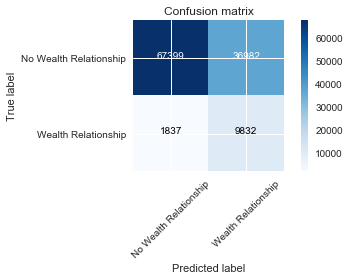

In [118]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y, predall)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["No Wealth Relationship", "Wealth Relationship"],
                      title='Confusion matrix')

In [121]:
from sklearn.ensemble import VotingClassifier

#set parameter grid
weight = [[0.12,0.56,0.03,0.08,0.19,0.02]]
#for i in range(10):
#  weight.append(np.random.dirichlet(np.ones(6),size=1)[0].tolist())
voters = ['soft']
param_grid = {'weights' : weight, 'voting' : voters}
print(weight)

#create and run grid search
overall = GridSearchCV(VotingClassifier(estimators=[('ada', best_ada), ('xg', best_xg), ('knn', best_knn), ('nn', best_nn), ('nlsvc', best_nlsvc), ('lr', best_lr)]), param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=3)
overall.fit(X_train_scale, y_train)

#extract the best params from 'grid_dt'
best_hyperparams = overall.best_params_
print(best_hyperparams)

#extract best CV score 
best_CV_score = overall.best_score_
print(best_CV_score)

#extract best model from grid_dt
best_overall = overall.best_estimator_

#Fit the model to the data
best = best_overall.fit(X_train_scale,y_train)

#make predictions on test data
predictions = best.predict(X_test_scale)

[[0.12, 0.56, 0.03, 0.08, 0.19, 0.02]]
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   44.4s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished
C:\Users\e4129\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


{'voting': 'soft', 'weights': [0.12, 0.56, 0.03, 0.08, 0.19, 0.02]}
0.765725563638158


C:\Users\e4129\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [123]:
from sklearn.metrics import classification_report,confusion_matrix

print(confusion_matrix(y_test,predictions))

print(classification_report(y_test,predictions, digits=3))

[[430 197]
 [111 429]]
              precision    recall  f1-score   support

           0      0.795     0.686     0.736       627
           1      0.685     0.794     0.736       540

   micro avg      0.736     0.736     0.736      1167
   macro avg      0.740     0.740     0.736      1167
weighted avg      0.744     0.736     0.736      1167



In [125]:
#make predictions on all data
predall = best.predict(X_train_all)

#create confusion & classification matrix for test data
print(confusion_matrix(y,predall))
print(classification_report(y,predall, digits=3))

[[70016 34365]
 [ 2066  9603]]
              precision    recall  f1-score   support

           0      0.971     0.671     0.794    104381
           1      0.218     0.823     0.345     11669

   micro avg      0.686     0.686     0.686    116050
   macro avg      0.595     0.747     0.569    116050
weighted avg      0.896     0.686     0.748    116050

